In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(22*22*64, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
def Accuracy(dataloader,model):     
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data in dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total



class CNNModel:
  def __init__(self, batch_size,epochs,lr):
    self.batchSize = batch_size
    self.epochs = epochs
    self.learningRate = lr
    self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    self.trainloader = None
    self.valLoader = None
    self.AccTrain = []
    self.AccVal = []
    self.Epoch = []
    self.Model = None
    self.loss = {}
    self.err = {}
    self.lossT = []
    # self.err['train'] = []
    self.lossV = []
    # self.err['val'] = []
    self.best = None
    self.bestLossT = None
    self.bestLossV = None

    # self.xepoch

  def classWiseAcc(self, dataloader, model):
      correct_pred = {classname: 0 for classname in self.classes}
      total_pred = {classname: 0 for classname in self.classes}

      # again no gradients needed
      with torch.no_grad():
          for data in dataloader:
              images, labels = data
              outputs = model(images)
              _, predictions = torch.max(outputs, 1)
              # collect the correct predictions for each class
              for label, prediction in zip(labels, predictions):
                  if label == prediction:
                      correct_pred[self.classes[label]] += 1
                  total_pred[self.classes[label]] += 1


      # print accuracy for each class
      for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


 
  def loadData(self):
    # Data transformations 
    normal_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    flip_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ,transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32)
        ])
    # Data Loading 

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=flip_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batchSize,
                                              shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=normal_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=self.batchSize,
                                            shuffle=False, num_workers=2)
    self.trainloader = trainloader
    self.valLoader = testloader
    print("Data Loaded")

  def valLoss(self,model,dataloader):
      running_loss = 0.0
      criterion = nn.CrossEntropyLoss()
      for i, data in enumerate(self.trainloader, 0):
          inputs, labels = data
          images = inputs.to(device)
          labels = labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

      no_of_batches = 50000/self.batchSize
      return running_loss/ no_of_batches

  def train(self):
    batches = 50000/self.batchSize
    Train_Acc=[]
    Test_Acc=[]
    Train_Loss=[]
    Test_Loss = []
    Epochs=[]
    running_loss = 0.0
    running_corrects = 0.0
    minLossT = 100
    minLossV = 100

    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=self.learningRate)
    for epoch in range(self.epochs):  
      running_loss = 0.0
      for i, data in enumerate(self.trainloader, 0):
          inputs, labels = data
          images = inputs.to(device)
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # Forward Pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backpropagation and optimizatuon

          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # if i % 4000 == 3999:    # print every 2000 mini-batches
      print(f' Epoch: {epoch + 1} loss: {running_loss / batches:.3f}')
      train_loss = running_loss / batches
      if(train_loss<minLossT):
        minLossT = train_loss
        self.bestLossT = minLossT
        self.best = model
      Train_Loss.append(train_loss)
      running_loss = 0.0
      with torch.no_grad():
        testAcc = Accuracy(self.valLoader,model)
        trainAcc = Accuracy(self.trainloader, model)
        Train_Acc.append(trainAcc)
        Test_Acc.append(testAcc)
        val_loss = self.valLoss(model,self.valLoader)
        if(val_loss<minLossV):
          minLossV = val_loss
          self.bestLossV = minLossV
        Test_Loss.append(val_loss)
        Epochs.append(epoch+1)
        print(f'Accuracy of the network on the 10000 test images: {testAcc} %')
        print(f'Accuracy of the network on the train images: {trainAcc} %')
    self.Model = model
    self.AccVal = Test_Acc
    self.AccTrain = Train_Acc
    self.Epoch = Epochs
    self.lossT = Train_Loss
    self.lossV = Test_Loss




In [ ]:
def drawAcc(TrainAcc,TestAcc,Epoch):
  x = Epoch
  y1= TrainAcc
  y2 = TestAcc

  plt.plot(x,y1,color='blue',label = 'Training Accuracy') # for training data 
  plt.plot(x,y2,color='red',label= 'Validation Accuracy') # for test data 
  plt.title("Accuracy Curve")
  plt.legend()
  plt.show()

#===============================================
#----------Draw loss curve ---------------------

def drawLoss(trainLoss,valLoss,Epoch):
  x = Epoch
  y1= trainLoss
  y2 = valLoss

  plt.plot(x,y1,color='blue',label = 'Training Loss') # for training data 
  plt.plot(x,y2,color='red',label= 'Validation Loss') # for test data 
  plt.title("Loss Curve")
  plt.legend()
  plt.show()

---------(lr = 0.001 )----------
Files already downloaded and verified
Files already downloaded and verified
Data Loaded
 Epoch: 1 loss: 1.768
Accuracy of the network on the 10000 test images: 47.93 %
Accuracy of the network on the train images: 48.292 %
 Epoch: 2 loss: 1.367
Accuracy of the network on the 10000 test images: 54.07 %
Accuracy of the network on the train images: 54.506 %
 Epoch: 3 loss: 1.204
Accuracy of the network on the 10000 test images: 60.68 %
Accuracy of the network on the train images: 61.828 %
 Epoch: 4 loss: 1.060
Accuracy of the network on the 10000 test images: 63.38 %
Accuracy of the network on the train images: 65.592 %
 Epoch: 5 loss: 0.944
Accuracy of the network on the 10000 test images: 66.64 %
Accuracy of the network on the train images: 70.22 %
 Epoch: 6 loss: 0.851
Accuracy of the network on the 10000 test images: 68.8 %
Accuracy of the network on the train images: 73.16 %
 Epoch: 7 loss: 0.776
Accuracy of the network on the 10000 test images: 70.16 

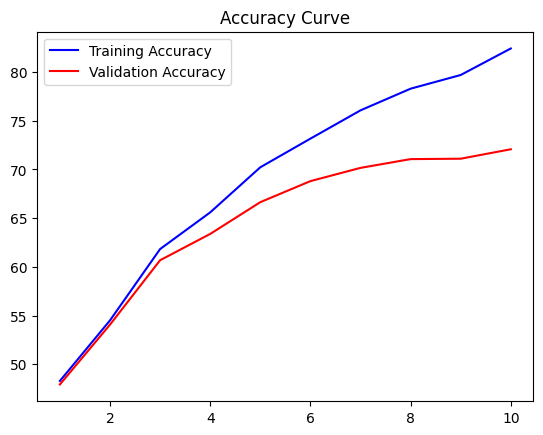

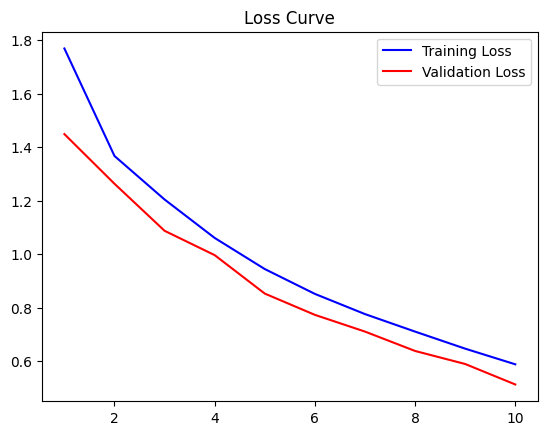

Class waise Accuracy on train Data
Accuracy for class: plane is 87.1 %
Accuracy for class: car   is 93.2 %
Accuracy for class: bird  is 71.4 %
Accuracy for class: cat   is 76.9 %
Accuracy for class: deer  is 81.7 %
Accuracy for class: dog   is 54.8 %
Accuracy for class: frog  is 87.3 %
Accuracy for class: horse is 89.3 %
Accuracy for class: ship  is 96.3 %
Accuracy for class: truck is 86.2 %

Class waise Accuracy on Val Data
Accuracy for class: plane is 77.8 %
Accuracy for class: car   is 85.1 %
Accuracy for class: bird  is 55.9 %
Accuracy for class: cat   is 62.1 %
Accuracy for class: deer  is 68.0 %
Accuracy for class: dog   is 44.5 %
Accuracy for class: frog  is 80.3 %
Accuracy for class: horse is 79.8 %
Accuracy for class: ship  is 88.5 %
Accuracy for class: truck is 78.7 %

---------(lr = 0.005 )----------
Files already downloaded and verified
Files already downloaded and verified
Data Loaded
 Epoch: 1 loss: 1.509
Accuracy of the network on the 10000 test images: 55.52 %
Accuracy 

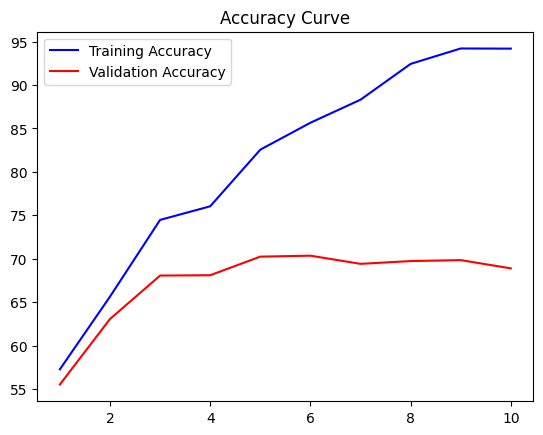

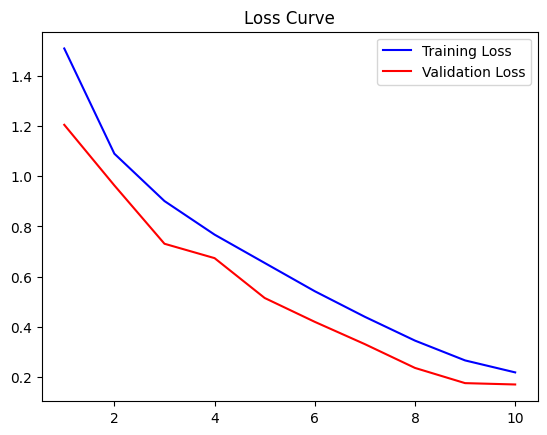

Class waise Accuracy on train Data
Accuracy for class: plane is 94.8 %
Accuracy for class: car   is 94.7 %
Accuracy for class: bird  is 94.8 %
Accuracy for class: cat   is 87.5 %
Accuracy for class: deer  is 95.4 %
Accuracy for class: dog   is 96.8 %
Accuracy for class: frog  is 95.0 %
Accuracy for class: horse is 95.9 %
Accuracy for class: ship  is 91.6 %
Accuracy for class: truck is 95.5 %

Class waise Accuracy on Val Data
Accuracy for class: plane is 75.4 %
Accuracy for class: car   is 75.4 %
Accuracy for class: bird  is 60.0 %
Accuracy for class: cat   is 46.4 %
Accuracy for class: deer  is 64.5 %
Accuracy for class: dog   is 69.8 %
Accuracy for class: frog  is 74.4 %
Accuracy for class: horse is 75.2 %
Accuracy for class: ship  is 71.0 %
Accuracy for class: truck is 76.8 %

---------(lr = 0.01 )----------
Files already downloaded and verified
Files already downloaded and verified
Data Loaded
 Epoch: 1 loss: 1.460
Accuracy of the network on the 10000 test images: 59.52 %
Accuracy o

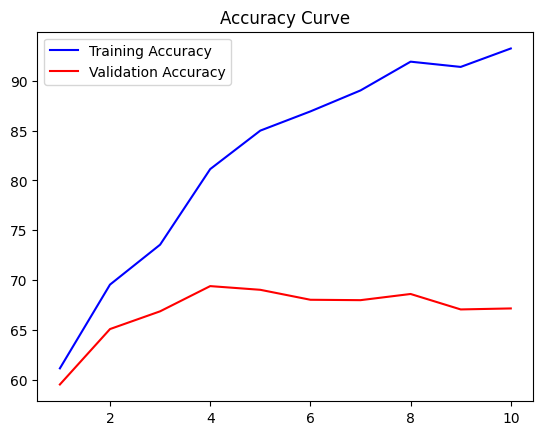

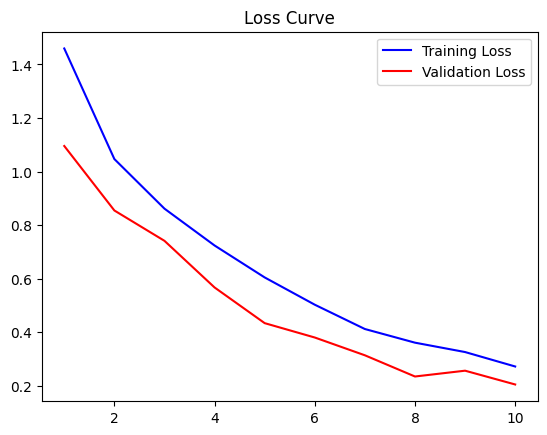

Class waise Accuracy on train Data
Accuracy for class: plane is 94.5 %
Accuracy for class: car   is 93.8 %
Accuracy for class: bird  is 91.7 %
Accuracy for class: cat   is 88.1 %
Accuracy for class: deer  is 93.8 %
Accuracy for class: dog   is 86.2 %
Accuracy for class: frog  is 93.6 %
Accuracy for class: horse is 96.9 %
Accuracy for class: ship  is 97.4 %
Accuracy for class: truck is 96.3 %

Class waise Accuracy on Val Data
Accuracy for class: plane is 72.2 %
Accuracy for class: car   is 76.1 %
Accuracy for class: bird  is 53.1 %
Accuracy for class: cat   is 48.3 %
Accuracy for class: deer  is 63.0 %
Accuracy for class: dog   is 50.6 %
Accuracy for class: frog  is 73.5 %
Accuracy for class: horse is 74.4 %
Accuracy for class: ship  is 83.1 %
Accuracy for class: truck is 77.2 %

---------(lr = 0.05 )----------
Files already downloaded and verified
Files already downloaded and verified
Data Loaded
 Epoch: 1 loss: 1.804
Accuracy of the network on the 10000 test images: 35.83 %
Accuracy o

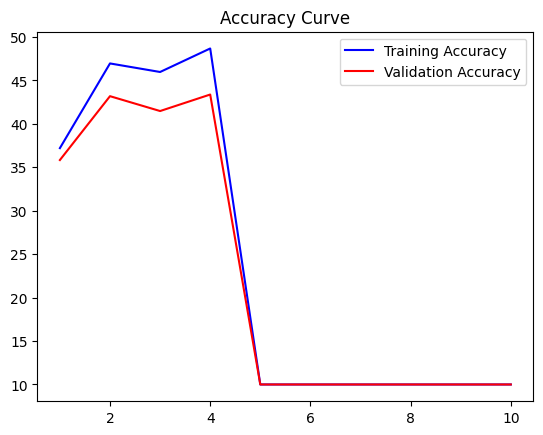

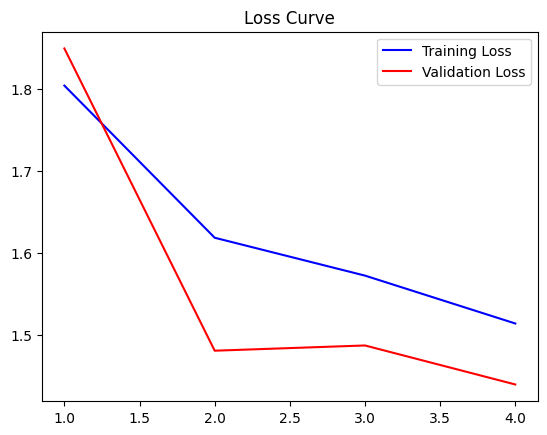

Class waise Accuracy on train Data
Accuracy for class: plane is 100.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %

Class waise Accuracy on Val Data
Accuracy for class: plane is 100.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %

Loss curve for different Learning rates..


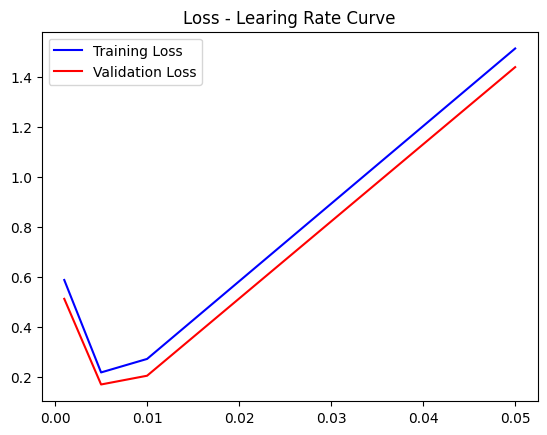

Accuracy curve for different Learning rates..


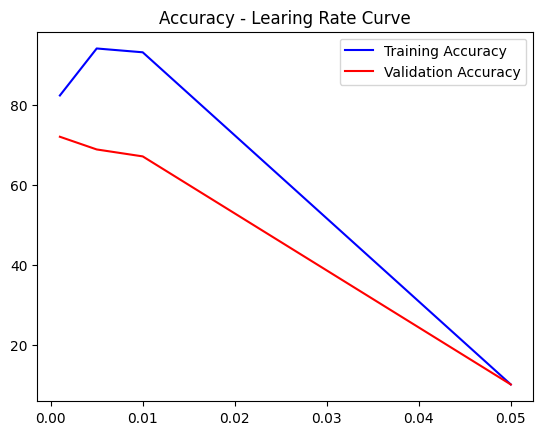

In [ ]:
def drawLR(x,y,z):
  plt.plot(x,y,color='blue',label = 'Training Accuracy') # for training data 
  plt.plot(x,z,color='red',label= 'Validation Accuracy') # for test data 
  plt.legend()
  plt.xlabel("Learning Rate")
  plt.ylabel("Accuracy")
  plt.show()
LR = [0.001,0.005,0.01,0.05]
ValAcc = []
ValLoss = []
TrainAcc = []
TrainLoss = []

Models = [0,0,0,0]
# 
i=0
for lr in LR:
  print("=====================================")
  print("---------("+"lr = "+str(lr)+" )----------")
  M = CNNModel(4,10,lr)
  M.loadData()
  M.train() 
  Models[i]=M
  model = M.best
  trainloader = M.trainloader
  valLoader = M.valLoader
  drawAcc(M.AccTrain,M.AccVal,M.Epoch)
  drawLoss(M.lossT,M.lossV,M.Epoch)
  accT = Accuracy(trainloader,model)
  accV = Accuracy(valLoader,model)
  ValAcc.append(accV)
  TrainAcc.append(accT)
  ValLoss.append(M.bestLossV)
  TrainLoss.append(M.bestLossT)

  print("Class waise Accuracy on train Data")
  M.classWiseAcc(trainloader,model)
  print()
  print("Class waise Accuracy on Val Data")
  M.classWiseAcc(valLoader,model)
  print()
  i+=1

print("=========================================")
print("Loss curve for different Learning rates..")

plt.plot(LR,TrainLoss,color='blue',label = 'Training Loss') # for training data 
plt.plot(LR,ValLoss,color='red',label= 'Validation Loss') # for test data 
plt.title("Loss - Learing Rate Curve")
plt.legend()
plt.show()


print("=========================================")
print("Accuracy curve for different Learning rates..")

plt.plot(LR,TrainAcc,color='blue',label = 'Training Accuracy') # for training data 
plt.plot(LR,ValAcc,color='red',label= 'Validation Accuracy') # for test data 
plt.title("Accuracy - Learing Rate Curve") 
plt.legend()
plt.show()


